# Imports

In [1]:
import sys
sys.path.append("/home/roozbeh/Morphology/McNeuron")
import McNeuron
import numpy as np
import pandas as pd
#import Asy
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy.linalg import inv
from collections import Counter
import pickle
from numpy import sqrt as sqrt
import operator
import matplotlib.ticker as plticker
from PIL import Image
from matplotlib import collections as mc
%matplotlib inline
import scipy.misc
import tifffile

#!/usr/bin/env python
from __future__ import print_function
import os,sys
from scipy import ndimage
from skimage import io
 

# Import Data
Here we select the timeframe for 3d image of the neuron + reconstructed neuron as swx

In [2]:
path = '/home/roozbeh/Morphology/Sam/Data/1409.4-CNTRL-FChet-P2-decon-wpl_MAX-crop-aligned-cut/'
swc_files = os.listdir(path+'SWC-traces/')
tiff_files = os.listdir(path+'tiff-images/')
max_files = os.listdir(path+'MAX/')

# path = '/home/roozbeh/Morphology/Sam/Data/Control-P4-1486-6/'
# swc_files = os.listdir(path+'1486-6_SWC/')
# tiff_files = os.listdir(path+'1486-6_deconvolved_soma-removed/')
# max_files = os.listdir(path+'1486-6_RAW/')

for i in range(len(max_files)):
    if swc_files[i][6:8] == '01':
        swc_files_number = i
    if tiff_files[i][6:8] == '01':
        tiff_files_number = i
    #print(max_files[i][27:29])
    if max_files[i][27:29] == '1-':   
        max_files_number = i
        
tiff_path = path+'tiff-images/'+tiff_files[tiff_files_number]
swc_path = path+'SWC-traces/'+swc_files[swc_files_number]
imarray_3d = io.imread(tiff_path)
soma_location = np.loadtxt(swc_path)[0,2:5]
soma_location[1] = 766-soma_location[1]

# Pre-procesing

In [14]:
def translate_neuron(neuron, v):

    neuron1 = deepcopy(neuron)
    neuron1.location[0, :] -= - v[0]
    neuron1.location[1, :] -= - v[1]
    neuron1.location[2, :] -= - v[2]
    
    return neuron1

def flip_neuron(neuron, flip_on=0):
    from copy import deepcopy
    neuron1 = deepcopy(neuron)
    neuron1.location[flip_on, :] = - neuron1.location[flip_on, :]
    
    return neuron1

def remove_soma_pixels(image, soma_location, radius):
    new_image = deepcopy(image)
    tickening_range = range(-radius, radius)
    x, y = np.meshgrid(tickening_range, tickening_range)
    
    d = x.shape[0]*x.shape[1]
    x = list(np.reshape(x,(1, d))[0])
    y = list(np.reshape(y,(1, d))[0])
    for xx, yy in zip(x, y) :  
        if xx * xx + yy * yy < radius**2:
            new_image[:, int(soma_location[1])+yy, int(soma_location[0])+xx]  = 0
    return new_image

def subsample_neuron(swc, length=1):
    soma_location = swc[0, 2:5]
    neuron = McNeuron.Neuron(swc)
    neuron = neuron.subsample(subsample_type='straigthen', length=length)
    neuron = McNeuron.Neuron(neuron)
    neuron = translate_neuron(neuron, v=soma_location)
    return neuron.get_swc()

def load_swc(swc_path, length=5):

    neuron = McNeuron.Neuron(swc_path)
    neuron = neuron.subsample(subsample_type='straigthen', length=length)
    neuron = McNeuron.Neuron(neuron)
    neuron = flip_neuron(neuron, flip_on=1)
    neuron = translate_neuron(neuron, v=soma_location)
    return neuron

Using functions to pre-process data

In [4]:
neuron = McNeuron.Neuron(swc_path)
neuron = neuron.subsample(subsample_type='straigthen', length=1)
neuron = McNeuron.Neuron(neuron)
neuron = flip_neuron(neuron, flip_on=1)
neuron = translate_neuron(neuron, v=soma_location)
image_max = imarray_3d[:, :, :].max(0)

# remove the part that are oversaturated
imarray_3d[imarray_3d==255] = 0
imarray_3d = remove_soma_pixels(image=imarray_3d, soma_location=soma_location, radius=70)

# Functions to visualize neuron and removing the traces

In [5]:
def neuron_patches(neuron,
            show_width=False,
            show_soma=False,
            line_width=1,
            line_width_scale=10,
            color=[0,0,1],
            color_line_width=1,
            color_range=['red', 'orange', 'gold', 'green', 'cyan',
              'blue', 'violet', 'gray', 'pink', 'brown', 'magenta'],
            node_index_red_after=-1,
            show_loop=[],
            red_index=np.array([]),
            node_color=[],
            shift=(0, 0),
            scale=(1, 1),
            save=[],
            pass_ax=False,
            axis=[1,0,0],
            rotation=0,
            format_save='eps',
            ax='',
            title =''):
    

    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    import matplotlib.cm as cm
    import matplotlib.animation as animation
    import pylab as pl
    from numpy.linalg import inv
    import matplotlib
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import itertools

    from copy import deepcopy
    import matplotlib.colors as mcolors
    if isinstance(neuron, np.ndarray):
        location = neuron[:,2:5].T
        widths= neuron[:,5]
        parent_index = neuron[:,6] -1
        parent_index[0] = 0
        n_node = neuron.shape[0]
        n_soma = len(np.where(neuron[:,1]==1)[0])
    else:
        location = deepcopy(neuron.location)
        widths= neuron.diameter
        parent_index = neuron.parent_index
        n_node = neuron.n_node
        n_soma = neuron.n_soma

    
    colors = np.ones([3, n_node])
    colors[0,:] = color[0]* colors[0,:]
    colors[1,:] = color[1]* colors[1,:]
    colors[2,:] = color[2]* colors[2,:]

    lines = []
    patches = []
    
    # Adding width
    linewidths = line_width*np.ones(n_node)
    if show_width:
        linewidths = widths*linewidths

    # Making red after a node
    
    if node_index_red_after >=0:
        ancestors = []
        par = node_index_red_after
        colors[:, par] = color
        linewidths[par] = line_width_scale*line_width
        ancestors.append(par)
        while par!=0:
            par = neuron.parent_index[par]
            ancestors.append(par)
            colors[:, par] = color
            linewidths[par] = line_width_scale*line_width
        red_index = np.array(ancestors)
    if len(show_loop) <10:
        color_range = list(np.random.rand(3, 10))
    else:
        color_range = list(mcolors.TABLEAU_COLORS.keys()) + \
        list(mcolors.CSS4_COLORS.keys())
    if len(show_loop) >0:
        
        for i in range(len(show_loop)):
            anc1 = get_ancestors(neuron.parent_index, show_loop[i][0])
            anc2 = get_ancestors(neuron.parent_index, show_loop[i][1])
            red_index = np.array(list(set(anc1)^set(anc2))).astype(int)
            for j in red_index:

                colors[:, j] = [1, 0, 0]
                linewidths[j] = color_line_width
    # Making line for each edge
    for i in range(n_node):
        j = int(parent_index[i])
        lines.append([(location[0,i] + shift[0],
                       location[1,i] + shift[1]),
                      (location[0,j] + shift[0],
                       location[1,j] + shift[1])])
        linewidths[i] = neuron.diameter[i]
    if len(node_color) > 0:
        colors = node_color
    max_x = max(location[0,:])
    min_x = min(location[0,:])
    max_y = max(location[1,:])
    min_y = min(location[1,:])
    return lines, linewidths, colors, max_x, max_y, min_x, min_y



def superimposed_neuron(image, neuron=[], show_neuron=False, node_colors=[]):



    # Set up figure
    fig=plt.figure(figsize=(15, 15))
    ax=fig.add_subplot(111)
    ax.imshow(255-image[:, :, :].max(0), cmap='gray')
    if show_neuron:
        # get the neuron patches
        lines, linewidths, colors, max_x, max_y, min_x, min_y = neuron_patches(neuron, show_width=True)
        if len(node_colors)>0:
            lc = mc.LineCollection(lines,
                                   linewidths=3*linewidths,
                                   alpha=.8,
                                   color=node_colors)
        else:
            lc = mc.LineCollection(lines,
                       linewidths=3*linewidths,
                       alpha=.8)
                               #alpha=1)


        ax.add_collection(lc);


def adjust_range(locations, max_range):
    return np.maximum(np.minimum(locations, max_range), 0)

def remove_traced_neuron(neuron, 
                         image, 
                         thickening_neuron_radius = 9, 
                         diameter_discrete = 1, 
                         z_resolution= 0,
                         diameter_sensetive=False):

    locations = np.floor(neuron.location).astype(int)
    new_image = deepcopy(image)
    tickening_range = range(-thickening_neuron_radius, thickening_neuron_radius)
    x, y, z = np.meshgrid(tickening_range, tickening_range, tickening_range)
    d = x.shape[0]*x.shape[1]*x.shape[2]
    x = list(np.reshape(x,(1, d))[0])
    y = list(np.reshape(y,(1, d))[0])
    z = list(np.reshape(z,(1, d))[0])
    new_image_shape = new_image.shape

    
    if diameter_sensetive is False:
        diameter_discrete = 1
    m_d = max(neuron.diameter)
    for diameter_range in range(diameter_discrete):
        ratio = diameter_range/float(diameter_discrete)
        nodes = neuron.diameter>=ratio*m_d 
        for xx, yy, zz in zip(x, y, z) :  
            if xx * xx + yy * yy + z_resolution* zz * zz < \
            ((ratio+1/(float(diameter_discrete)))*thickening_neuron_radius)**2:
                new_image[adjust_range(locations[2, nodes]+zz, new_image_shape[0]-1),
                          adjust_range(locations[1, nodes]+yy, new_image_shape[1]-1),
                          adjust_range(locations[0, nodes]+xx, new_image_shape[2]-1)]  = 0

    new_image = ndimage.median_filter(new_image, 3)

    return new_image

# Plotting
### Max projections

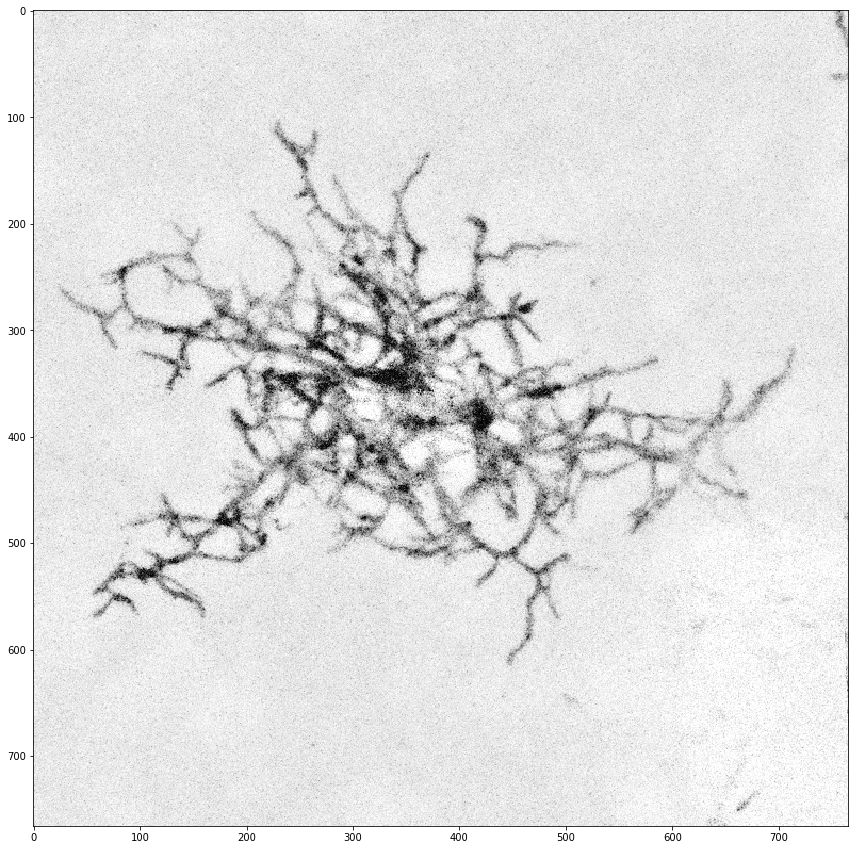

In [6]:
imarray_3d_all = io.imread(path+'tiff-images/'+tiff_files[tiff_files_number])
imarray_3d_all[imarray_3d_all==255] = 0
superimposed_neuron(image=imarray_3d_all, show_neuron=False)

## Max projections superimposed with the traced neuron

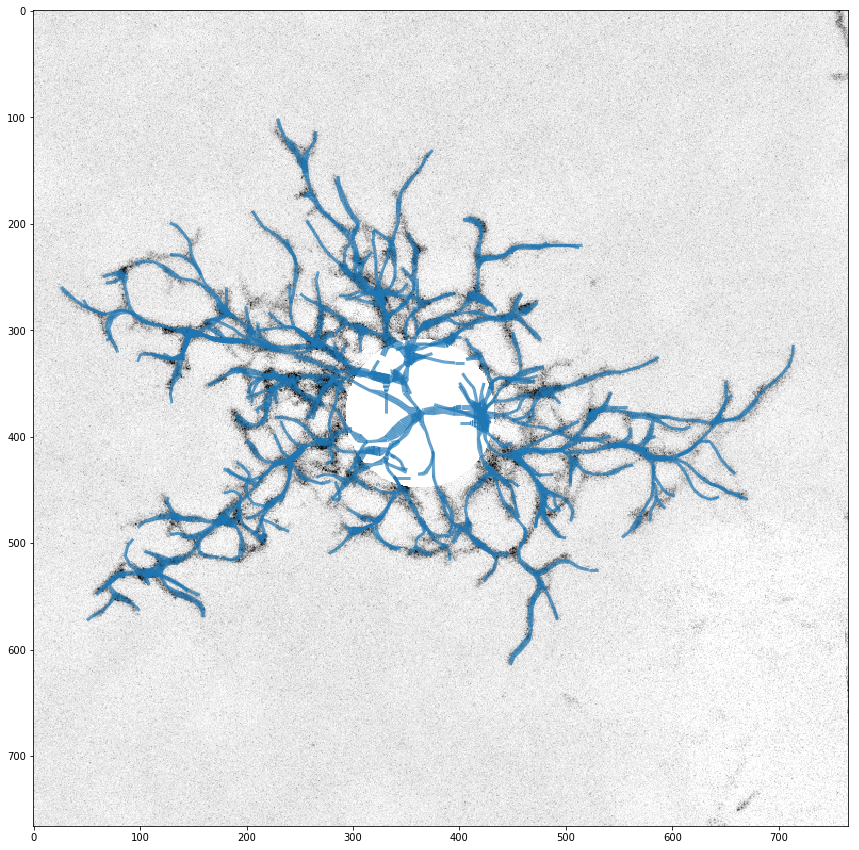

In [7]:
superimposed_neuron(neuron=deepcopy(neuron), image=imarray_3d, show_neuron=True)

## Thickening the neuron to find the area not covered in the tracing
later these areas are used to find the part of morphology participating in making loops

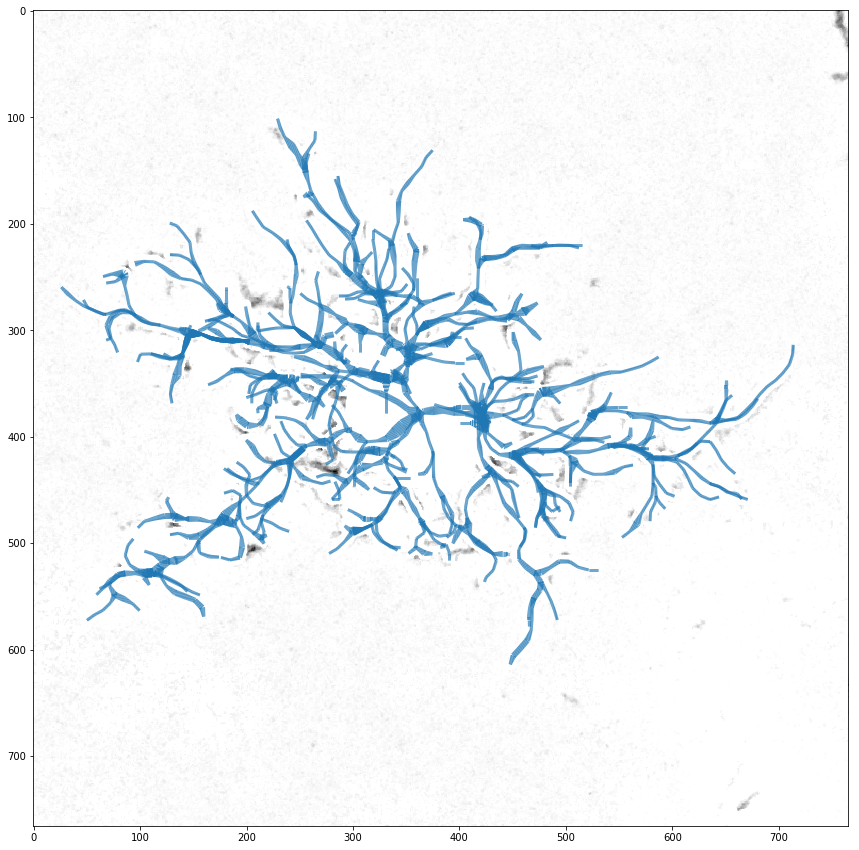

In [8]:
image_removed_neuron = remove_traced_neuron(neuron=deepcopy(neuron), 
                         image=imarray_3d, 
                         thickening_neuron_radius = 6, 
                         diameter_discrete = 2, 
                                 z_resolution=.2,
                                diameter_sensetive=False);
superimposed_neuron(neuron=deepcopy(neuron), image=image_removed_neuron, show_neuron=True)

# fig=plt.figure(figsize=(15, 15))
# ax=fig.add_subplot(111)
# ax.imshow(255-new_image[20,:,:], cmap='gray');

## Save the raw data when neuron is emptied
We save is as .tiff to use it in Vaa3D

In [10]:
tifffile.imsave('image_removed_neuron.tif', image_removed_neuron)

# Tracing remaining neurites ....
Using MOST_tracing. Threshold can be set to 10. Also keep in mind to trace for whole 3d image!

## Plotting new neurites and neuron

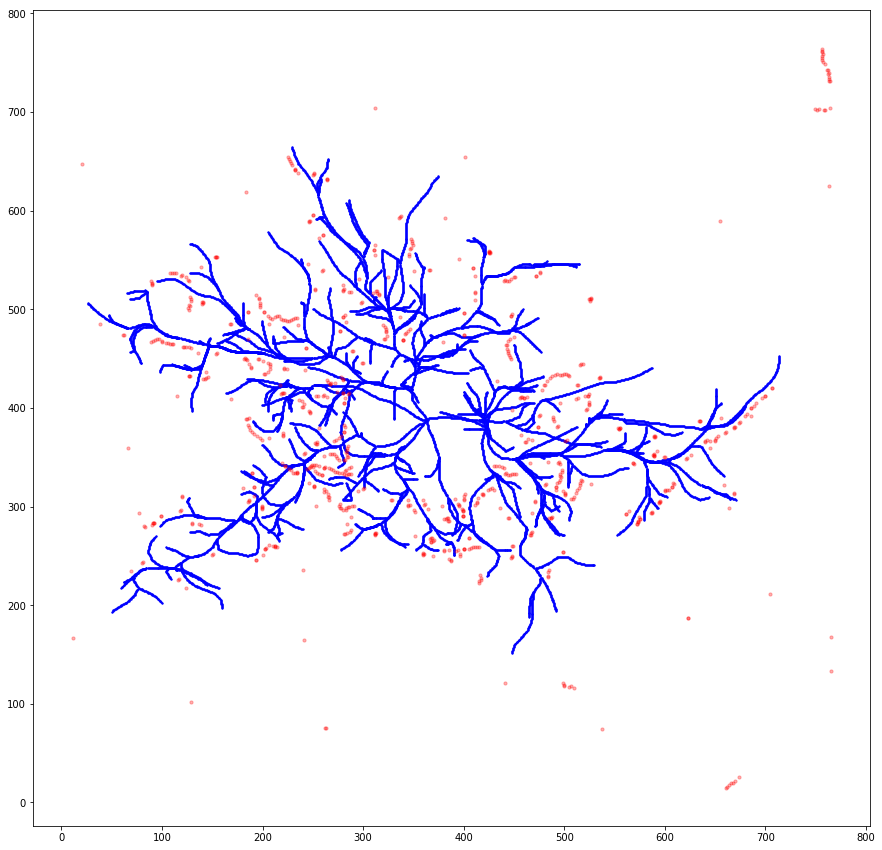

In [11]:
neurites = np.loadtxt('image_removed_neuron (1).swc')
fig=plt.figure(figsize=(15, 15))
plt.scatter(neuron.location[0, :], 766 - neuron.location[1, :], s = 2, color='b', cmap='gray');
plt.scatter(neurites[:, 2], neurites[:, 3], s = 10, color='r', alpha=.3);

# Functions to add loops to neuron

In [15]:
def make_me_loopy(neuron, neurites, max_dis_neurite_from_neuron):
    new_neuron = deepcopy(neuron)
    list_all_traces = list_traces(neurites)
    for i in range(len(list_all_traces)):
            new_neuron = add_neurite(neuron=new_neuron, 
                                     neurite=list_all_traces[i], 
                                     max_dis_neurite_from_neuron= max_dis_neurite_from_neuron)
    return new_neuron

def list_traces(neurites):
    list_all_traces = []
    starting_points = np.where(neurites[:, 6]==-1)[0]
    for i in range(len(starting_points)-1):
        neurite = deepcopy(neurites[starting_points[i]:starting_points[i+1], :])
        if starting_points[i+1]- starting_points[i] >1:
            #print('yes')
            neurite[:, 6] = neurite[:, 6] - starting_points[i]
            neurite[0, 6] = -1
            list_all_traces.append(neurite)
    return list_all_traces

def find_closest(neuron, point, max_dis = 10):
    x = neuron[:, 2]-point[0]
    y = neuron[:, 3]-point[1]
    z = neuron[:, 4]-point[2]
    dis = x**2 + y**2 + z**2
    if min(dis) < max_dis**2:
        return np.argmin(dis)#, np.sqrt(min(dis)) 
    else:
        return -1
    
def add_neurite(neuron, neurite, max_dis_neurite_from_neuron):    
    n_node_neuron = neuron.shape[0]
    n_node_neurite = neurite.shape[0]  
    neuron_node_close_start_pt = find_closest(neuron, neurite[0, 2:5], max_dis = max_dis_neurite_from_neuron)
    new_neuron = deepcopy(neuron)    
    if neuron_node_close_start_pt != -1: 
        new_neurite = deepcopy(neurite)

        new_neurite[0, 6] = neuron_node_close_start_pt+1
        new_neurite[1:, 6] = n_node_neuron + new_neurite[1:, 6]

        
        neurite_obj = McNeuron.Neuron(neurite)
        neurite_obj.set_branch_order()
        ends = np.where(neurite_obj.features['branch order']==0)[0]    
        for i in range(len(ends)):
            neuron_nodes_close_end_pt = find_closest(neuron, neurite[ends[i], 2:5], 
                                                     max_dis = max_dis_neurite_from_neuron) 
            #print(neurite[ends[i], 2:5])
            #print(neuron[neuron_nodes_close_end_pt, :])
            if neuron_nodes_close_end_pt != -1:
                new_node = neuron[neuron_nodes_close_end_pt, :]
                new_node[6] =  n_node_neuron + ends[i] +1
                new_neurite = np.append(new_neurite, np.expand_dims(new_node,0), 0)

        new_neuron = np.append(new_neuron, new_neurite, 0)
        new_neuron[:, 0] = 1+ np.arange(0, new_neuron.shape[0])
        #print(new_neuron.shape)
    return new_neuron


## One loop added

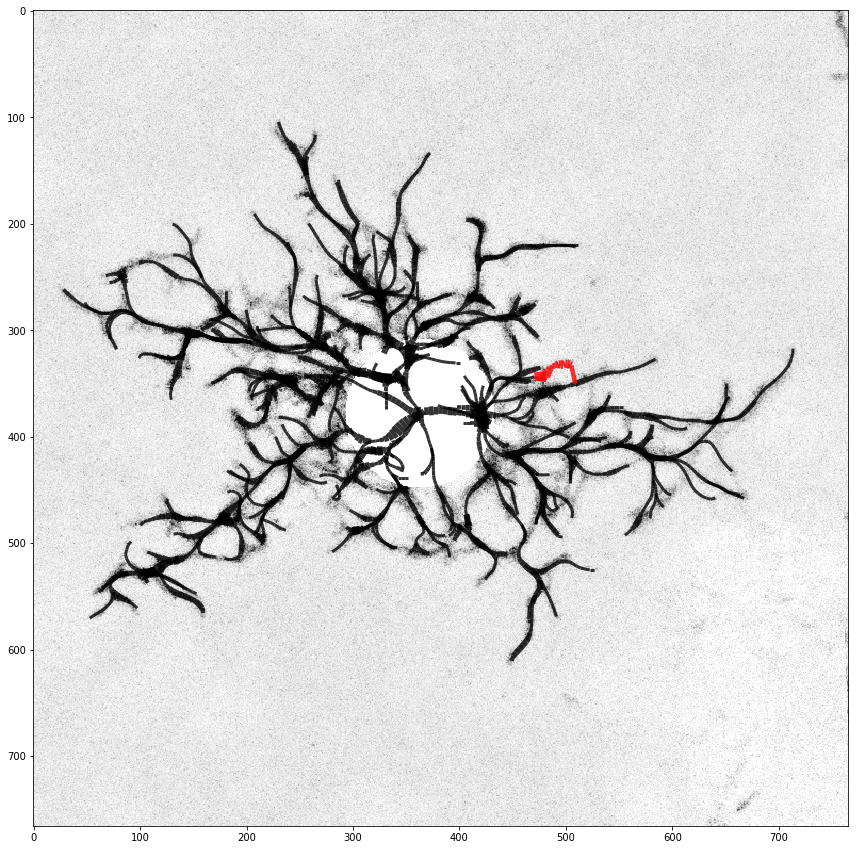

In [16]:
initial_neuron = subsample_neuron(np.loadtxt(swc_path), length=5)
neurites = np.loadtxt('image_removed_neuron (1).swc')
list_all_traces = list_traces(neurites)
new_swc = add_neurite(neuron=initial_neuron, neurite=list_all_traces[50], 
                                         max_dis_neurite_from_neuron=20)
new_neuron = McNeuron.Neuron(new_swc)
new_neuron = flip_neuron(new_neuron, flip_on=1)
new_neuron = translate_neuron(new_neuron, v=soma_location)
#np.where(initial_neuron - new_swc)
#new_swc[-2:, :]
colors = np.zeros([new_neuron.n_node, 3])
colors[initial_neuron.shape[0]:, 0] = 1
superimposed_neuron(neuron=deepcopy(new_neuron), image=imarray_3d, show_neuron=True, node_colors=colors)

# All the loops are added

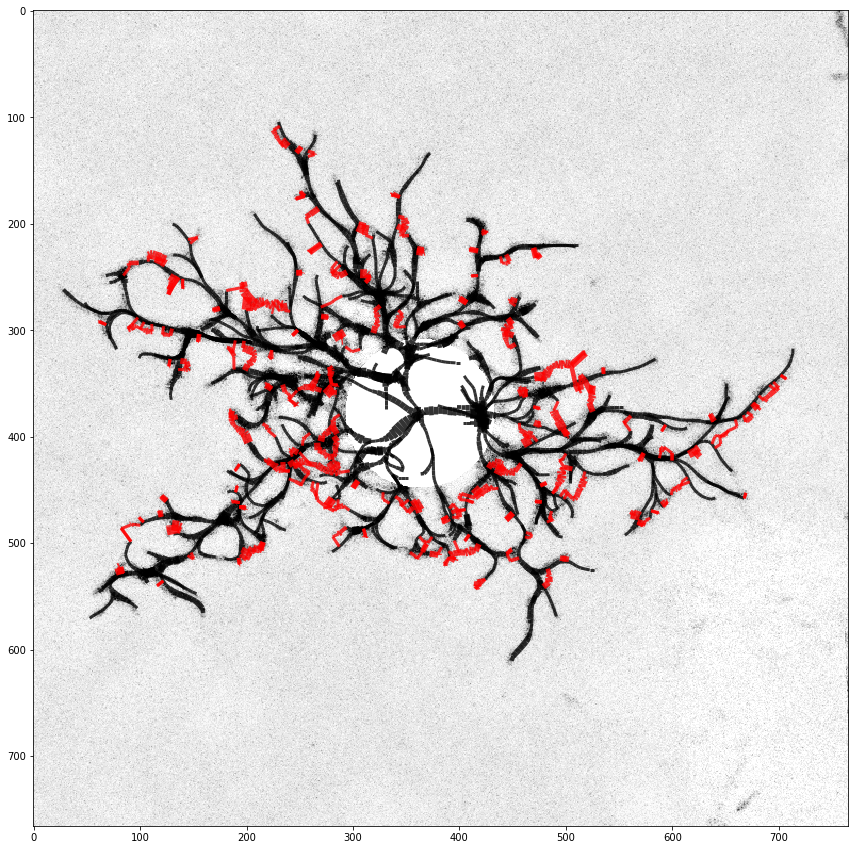

In [18]:
initial_neuron = subsample_neuron(np.loadtxt(swc_path), length=5)
neurites = np.loadtxt('image_removed_neuron (1).swc')
new_swc = make_me_loopy(neuron=initial_neuron, neurites=neurites,
                          max_dis_neurite_from_neuron=20)

new_neuron = McNeuron.Neuron(new_swc)
new_neuron = flip_neuron(new_neuron, flip_on=1)
new_neuron = translate_neuron(new_neuron, v=soma_location)

colors = np.zeros([new_neuron.n_node, 3])
colors[initial_neuron.shape[0]:, 0] = 1
superimposed_neuron(neuron=deepcopy(new_neuron), image=imarray_3d, show_neuron=True, node_colors=colors)

# The final output

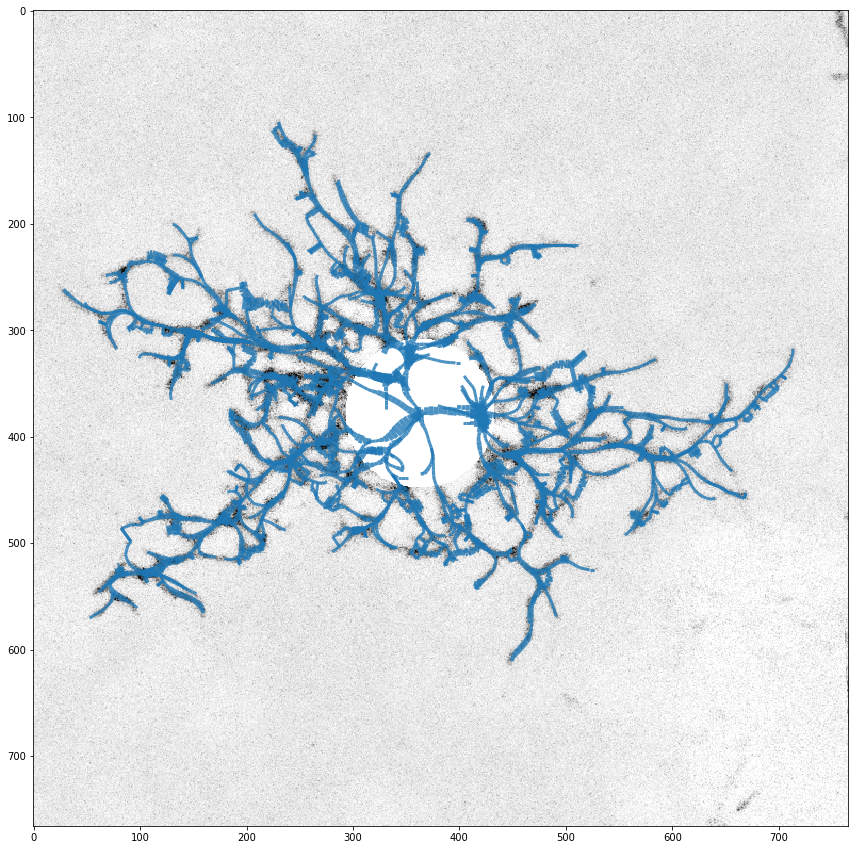

In [19]:
superimposed_neuron(neuron=deepcopy(new_neuron), image=imarray_3d, show_neuron=True)

# Save it as with right format for Vaa3d

In [ ]:
np.set_printoptions(suppress=True)
np.savetxt('with_loop.swc', new_neuron.get_swc(), fmt='%i %i %f %f %f %f %i')

# Pipeline in one shot

In [ ]:
imarray_3d = io.imread(tiff_path)
width = imarray_3d.shape[1]
soma_location = np.loadtxt(swc_path)[0,2:5]
soma_location[1] = width-soma_location[1]
    
neuron = load_swc(swc_path, length=5)

image_max = imarray_3d[:, :, :].max(0)

# remove the part that are oversaturated
imarray_3d[imarray_3d==255] = 0
imarray_3d = remove_soma_pixels(image=imarray_3d, soma_location=soma_location, radius=70)

image_removed_neuron = remove_traced_neuron(neuron=deepcopy(neuron), 
                         image=imarray_3d, 
                         thickening_neuron_radius = 6, 
                         diameter_discrete = 2, 
                         z_resolution=.2,
                         diameter_sensetive=False);

tifffile.imsave('image_removed_neuron.tif', image_removed_neuron)

neurites = np.loadtxt('image_removed_neuron (1).swc')

initial_neuron = subsample_neuron(np.loadtxt(swc_path), length=5)
neurites = np.loadtxt('image_removed_neuron (1).swc')
new_swc = make_me_loopy(neuron=initial_neuron, 
                        neurites=neurites,
                        max_dis_neurite_from_neuron=20)

new_neuron = McNeuron.Neuron(new_swc)
new_neuron = flip_neuron(new_neuron, flip_on=1)
new_neuron = translate_neuron(new_neuron, v=soma_location)

np.savetxt('with_loop.swc', new_neuron.get_swc(), fmt='%i %i %f %f %f %f %i')